#### Import libraries / dataset / split data / encoder

In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # statistical data visualization

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
import time



import warnings


warnings.filterwarnings('ignore')        

In [6]:
data = 'dataset/car_evaluation.csv'

df = pd.read_csv(data, header=None)
# view dimensions of dataset

df.shape

(1728, 7)

In [7]:
# preview the dataset

df.head()

,0,1,2,3,4,5,6
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [8]:
col_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']


df.columns = col_names

col_names

['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']

In [9]:
# let's again preview the dataset
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [11]:
col_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']


for col in col_names:
    
    print(df[col].value_counts())   

buying
vhigh    432
high     432
med      432
low      432
Name: count, dtype: int64
maint
vhigh    432
high     432
med      432
low      432
Name: count, dtype: int64
doors
2        432
3        432
4        432
5more    432
Name: count, dtype: int64
persons
2       576
4       576
more    576
Name: count, dtype: int64
lug_boot
small    576
med      576
big      576
Name: count, dtype: int64
safety
low     576
med     576
high    576
Name: count, dtype: int64
class
unacc    1210
acc       384
good       69
vgood      65
Name: count, dtype: int64


In [12]:
class_counts=df['class'].value_counts()
print(class_counts)

class
unacc    1210
acc       384
good       69
vgood      65
Name: count, dtype: int64


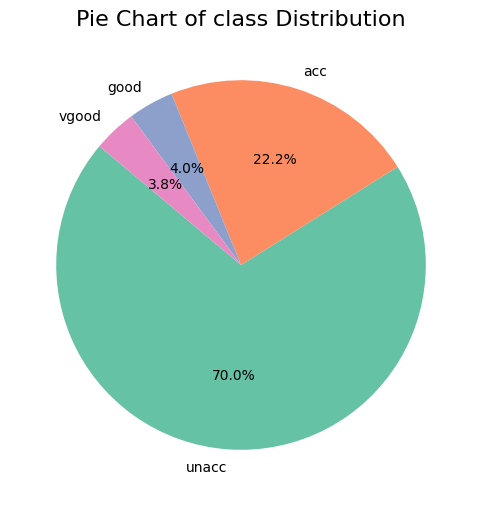

In [13]:
plt.figure(figsize=(8, 6))
plt.pie(
    class_counts,
    labels=class_counts.index,
    autopct="%1.1f%%",
    startangle=140,
    colors=sns.color_palette("Set2"),
)
plt.title("Pie Chart of class Distribution", fontsize=16)
plt.show()

In [14]:
df.isnull().sum()

buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64

In [15]:
X = df.drop(['class'], axis=1)

y = df['class']

# split data into training and testing sets


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

# check the shape of X_train and X_test

X_train.shape, X_test.shape

((1157, 6), (571, 6))

In [16]:
# check data types in X_train

X_train.dtypes

buying      object
maint       object
doors       object
persons     object
lug_boot    object
safety      object
dtype: object

In [17]:
X_train.head()

,buying,maint,doors,persons,lug_boot,safety
48,vhigh,vhigh,3,more,med,low
468,high,vhigh,3,4,small,low
155,vhigh,high,3,more,small,high
1721,low,low,5more,more,small,high
1208,med,low,2,more,small,high


In [18]:
import category_encoders as ce
# encode categorical variables with ordinal encoding

encoder = ce.OrdinalEncoder(cols=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'])


X_train = encoder.fit_transform(X_train)

X_test = encoder.transform(X_test)

X_train.head()


,buying,maint,doors,persons,lug_boot,safety
48,1,1,1,1,1,1
468,2,1,1,2,2,1
155,1,2,1,1,2,2
1721,3,3,2,1,2,2
1208,4,3,3,1,2,2


In [19]:
X_test.head()


,buying,maint,doors,persons,lug_boot,safety
599,2,2,4,3,1,2
1201,4,3,3,2,1,3
628,2,2,2,3,3,3
1498,3,2,2,2,1,3
1263,4,3,4,1,1,1


#### Attempt 1: Using Grid Search and Randomized Search to find the best parameters for our model

In [20]:
# Parameter Grid
param_options = {
    "n_estimators": [100, 1000],  # Number of trees in the forest
    "criterion": ["gini", "entropy"],  # Function to measure the quality of a split
    "max_features": [1, 8, 'sqrt', 'log2', None],  # Number of features to consider at every split
    "max_depth": [None, 10, 20, 30],  # Maximum number of levels in tree
    "bootstrap": [True, False]  # Method of selecting samples for training each tree
}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier()

# GridSearchCV
start_time = time.time()
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_options,
    scoring="accuracy",
    cv=5,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)  # Fit GridSearchCV to the data
end_time = time.time()
grid_search_time = end_time - start_time

# RandomizedSearchCV with a similar range of parameter options but using distributions where applicable
start_time = time.time()
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions={
        "n_estimators": randint(100, 1000),
        "criterion": ["gini", "entropy"],
        "max_features": [1, 8, 'sqrt', 'log2', None],
        "max_depth": [None, 10, 20, 30],
        "bootstrap": [True, False]
    },
    n_iter=100,
    scoring="accuracy",
    cv=5,
    n_jobs=-1
)
random_search.fit(X_train, y_train)  # Fit RandomizedSearchCV to the data
end_time = time.time()
random_search_time = end_time - start_time

# Results
best_params_random = random_search.best_params_
best_score_random = random_search.best_score_
best_params_grid = grid_search.best_params_
best_score_grid = grid_search.best_score_

# Print the results
print(f"Grid Search took {grid_search_time:.2f} seconds.")
print("Grid Search Best Parameters:", best_params_grid)
print("Grid Search Best Score:", best_score_grid)
print("================================================")
print(f"Randomized Search took {random_search_time:.2f} seconds.")
print("Randomized Search Best Parameters:", best_params_random)
print("Randomized Search Best Score:", best_score_random)


# Compare the best scores from both searches and select the best parameters
best_params = best_params_grid if best_score_grid >= best_score_random else best_params_random
     

Grid Search took 56.86 seconds.
Grid Search Best Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'n_estimators': 100}
Grid Search Best Score: 0.9637035378414689
Randomized Search took 35.29 seconds.
Randomized Search Best Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 20, 'max_features': 8, 'n_estimators': 616}
Randomized Search Best Score: 0.9628414688759517


#### Training Data


In [48]:
# import Random Forest classifier

from sklearn.ensemble import RandomForestClassifier



# instantiate the classifier 

rfc = RandomForestClassifier(random_state=0)



# fit the model

rfc.fit(X_train, y_train)



# Predict the Test set results

y_pred = rfc.predict(X_test)



# Check accuracy score 


print('Model accuracy score with 100 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with 100 decision-trees : 0.9457


#### what is this?


In [49]:
# instantiate the classifier with n_estimators = 1000

rfc_100 = RandomForestClassifier(n_estimators=1000, random_state=0)



# fit the model to the training set

rfc_100.fit(X_train, y_train)



# Predict on the test set results

y_pred_100 = rfc_100.predict(X_test)



# Check accuracy score 

print('Model accuracy score with 1000 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred_100)))

Model accuracy score with 1000 decision-trees : 0.9422


In [50]:
# create the classifier with n_estimators = 100

clf = RandomForestClassifier(n_estimators=100, random_state=0)



# fit the model to the training set

clf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

#### Attempt 2: Feature Importance and train again

In [51]:
# view the feature scores

feature_scores = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

safety      0.295319
persons     0.233856
buying      0.151734
maint       0.146653
lug_boot    0.100048
doors       0.072389
dtype: float64

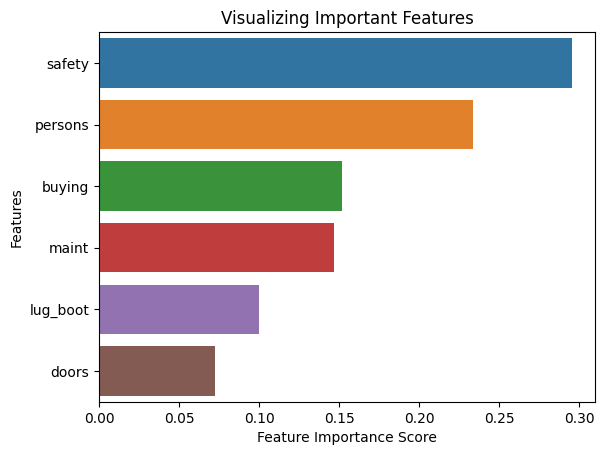

In [52]:
# Creating a seaborn bar plot

sns.barplot(x=feature_scores, y=feature_scores.index)



# Add labels to the graph

plt.xlabel('Feature Importance Score')

plt.ylabel('Features')



# Add title to the graph

plt.title("Visualizing Important Features")



# Visualize the graph

plt.show()

In [53]:
# declare feature vector and target variable

X = df.drop(['class', 'doors'], axis=1)

y = df['class']
# split data into training and testing sets


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
# encode categorical variables with ordinal encoding

encoder = ce.OrdinalEncoder(cols=['buying', 'maint', 'persons', 'lug_boot', 'safety'])


X_train = encoder.fit_transform(X_train)

X_test = encoder.transform(X_test)

# instantiate the classifier with n_estimators = 100

clf = RandomForestClassifier(random_state=0)



# fit the model to the training set

clf.fit(X_train, y_train)


# Predict on the test set results

y_pred = clf.predict(X_test)



# Check accuracy score 

print('Model accuracy score with doors variable removed : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with doors variable removed : 0.9264


#### Finall Results

In [54]:
# Print the Confusion Matrix and slice it into four pieces


cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)

Confusion matrix

 [[104  12  10   3]
 [  0  18   0   2]
 [ 10   0 387   0]
 [  3   2   0  20]]


In [55]:

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         acc       0.89      0.81      0.85       129
        good       0.56      0.90      0.69        20
       unacc       0.97      0.97      0.97       397
       vgood       0.80      0.80      0.80        25

    accuracy                           0.93       571
   macro avg       0.81      0.87      0.83       571
weighted avg       0.93      0.93      0.93       571



#### Attempt 3: Using Default parameters for our model

In [24]:
rf_default = RandomForestClassifier(n_estimators = 1000, max_features = 1) # (1, nd)

start_time = time.time()

# Fit the model to the training data
rf_default.fit(X_train, y_train)
y_pred = rf_default.predict(X_test)

end_time = time.time()
rf_default_time = end_time - start_time

accuracy = accuracy_score(y_test, y_pred)

# Manually select and display the desired parameters
selected_params = {
    'bootstrap': rf_default.bootstrap,
    'criterion': rf_default.criterion,
    'max_depth': rf_default.max_depth,
    'max_features': rf_default.max_features,
    'n_estimators': rf_default.n_estimators
}

print("Selected params:", selected_params)
print(f"Accuracy: {accuracy:.2f}")
print(f"training took {rf_default_time:.2f} seconds.")

Selected params: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'n_estimators': 1000}
Accuracy: 0.94
training took 1.46 seconds.
